# EDA of dataset "acon96/Home-Assistant-Requests"

### Setup, install and import libraries 

In [1]:
!pip install -q datasets pandas numpy seaborn matplotlib plotly wordcloud orjson ujson

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import json

### Load dataset

In [4]:
dataset = load_dataset("acon96/Home-Assistant-Requests")

# Train split has most of the data
train_data = dataset['train']

print(train_data[0])  # show first entry

{'conversations': [{'from': 'system', 'value': "You are 'Al', a helpful AI Assistant that controls the devices in a house. Complete the following task as instructed or answer the following question with the information provided only.\nServices: cover.close_cover(), cover.open_cover(), cover.stop_cover(), cover.toggle(), climate.set_fan_mode(fan_mode), climate.set_humidity(humidity), climate.set_hvac_mode(), climate.set_preset_mode(), climate.set_temperature(temperature), climate.toggle(), climate.turn_off(), climate.turn_on(), fan.decrease_speed(), fan.increase_speed(), fan.toggle(), fan.turn_off(), fan.turn_on(), cover.close_cover(), cover.open_cover(), cover.stop_cover(), cover.toggle(), light.toggle(), light.turn_off(), light.turn_on(rgb_color,brightness), switch.toggle(), switch.turn_off(), switch.turn_on(), timer.add_item(item), timer.cancel(), timer.pause()\nDevices:\nlight.front_lounge_ge 'Front Lounge Light' = on;saddlebrown (114, 71, 52);69%\nlight.front_bedroom_homekit 'Front

### Convert into a DataFrame

In [5]:
# -----------------------------------------
# Each sample has conversation (system, user, assistant)
# We'll extract user queries & assistant responses
# -----------------------------------------
def parse_conversation(example):
    user_text = None
    assistant_text = None
    system_text = None
    
    for turn in example:
        if turn['from'] == 'system':
            system_text = turn['value']
        elif turn['from'] == 'user':
            user_text = turn['value']
        elif turn['from'] == 'assistant':
            assistant_text = turn['value']
    return system_text, user_text, assistant_text

conversations = [parse_conversation(conv) for conv in train_data['conversations']]

df = pd.DataFrame(conversations, columns=['system', 'user', 'assistant'])
df.head()

,system,user,assistant
0,"You are 'Al', a helpful AI Assistant that cont...",lower the kitchen blinds,closing the blinds as you requested.\n```homea...
1,"You are 'Al', a helpful AI Assistant that cont...",lower the kitchen blinds,shutting Kitchen as requested\n```homeassistan...
2,"You are 'Al', a helpful AI Assistant that cont...",lower the kitchen blinds,closing the blinds as you requested.\n```homea...
3,"You are 'Al', a helpful AI Assistant that cont...",lower the kitchen blinds,closing the blinds as you requested.\n```homea...
4,"You are 'Al', a helpful AI Assistant that cont...",lower the kitchen blinds,shutting Kitchen as requested\n```homeassistan...


### Basic Info

In [6]:
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nSample User Queries:\n", df['user'].sample(5).to_list())

Dataset Shape: (33361, 3)

Missing Values:
 system       0
user         0
assistant    0
dtype: int64

Sample User Queries:
 ['deactivate the light on the porch', "can you set back corridor light's brightness level to 34 percent?", 'start the general purpose timer timer for six minutes and forty-five seconds.', 'please shut off the morning coffee brew timer timer.', 'could you turn on the porch light please?']


### Text Length Analysis

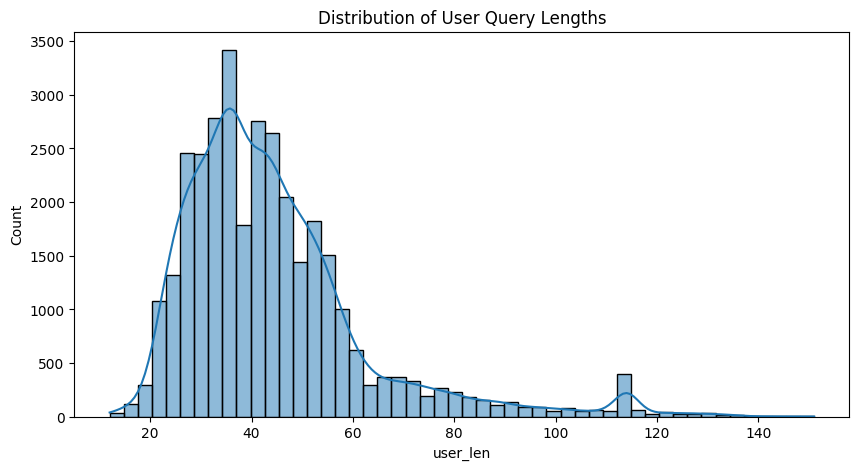

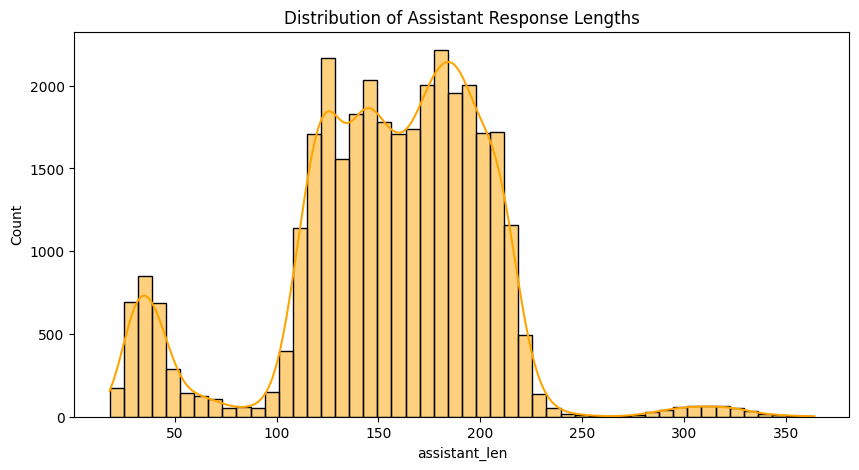

In [7]:
df['user_len'] = df['user'].str.len()
df['assistant_len'] = df['assistant'].str.len()

plt.figure(figsize=(10,5))
sns.histplot(df['user_len'], bins=50, kde=True)
plt.title("Distribution of User Query Lengths")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df['assistant_len'], bins=50, kde=True, color="orange")
plt.title("Distribution of Assistant Response Lengths")
plt.show()


### Extract Home Assistant Commands from Assistant

In [8]:
import re

def extract_service(text):
    match = re.search(r'"service":\s*"([^"]+)"', text)
    return match.group(1) if match else None

def extract_device(text):
    match = re.search(r'"target_device":\s*"([^"]+)"', text)
    return match.group(1) if match else None

df['service'] = df['assistant'].apply(extract_service)
df['device'] = df['assistant'].apply(extract_device)

print(df[['user','service','device']].head(10))

                           user      service             device
0      lower the kitchen blinds  cover.close      cover.kitchen
1      lower the kitchen blinds  cover.close      cover.kitchen
2      lower the kitchen blinds  cover.close      cover.kitchen
3      lower the kitchen blinds  cover.close      cover.kitchen
4      lower the kitchen blinds  cover.close      cover.kitchen
5  close the living room blinds  cover.close  cover.living_room
6  close the living room blinds  cover.close  cover.living_room
7  close the living room blinds  cover.close  cover.living_room
8  close the living room blinds  cover.close  cover.living_room
9  close the living room blinds  cover.close  cover.living_room


### Most Common Services & Devices

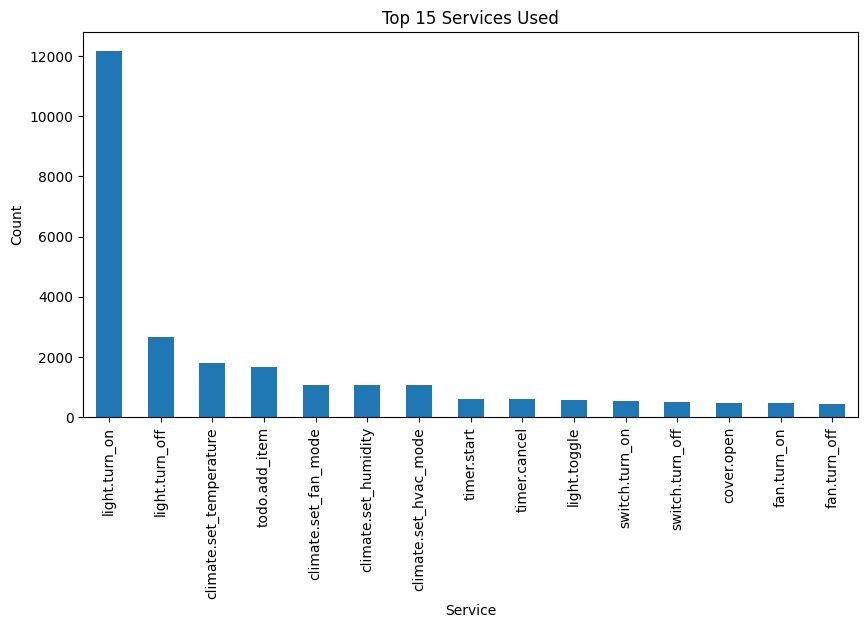

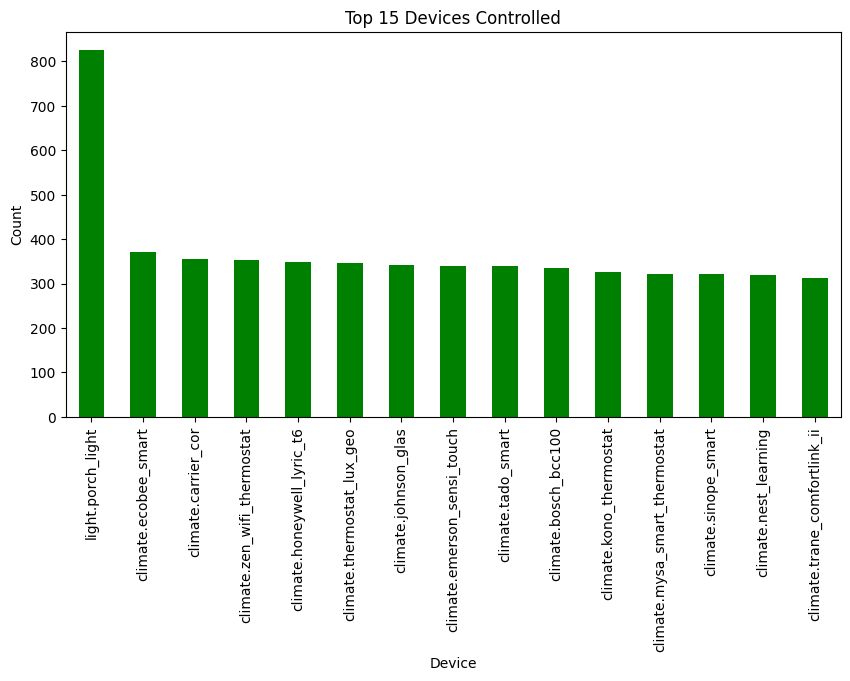

In [9]:
plt.figure(figsize=(10,5))
df['service'].value_counts().head(15).plot(kind='bar')
plt.title("Top 15 Services Used")
plt.xlabel("Service")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,5))
df['device'].value_counts().head(15).plot(kind='bar', color='green')
plt.title("Top 15 Devices Controlled")
plt.xlabel("Device")
plt.ylabel("Count")
plt.show()

### Word Cloud for User Queries

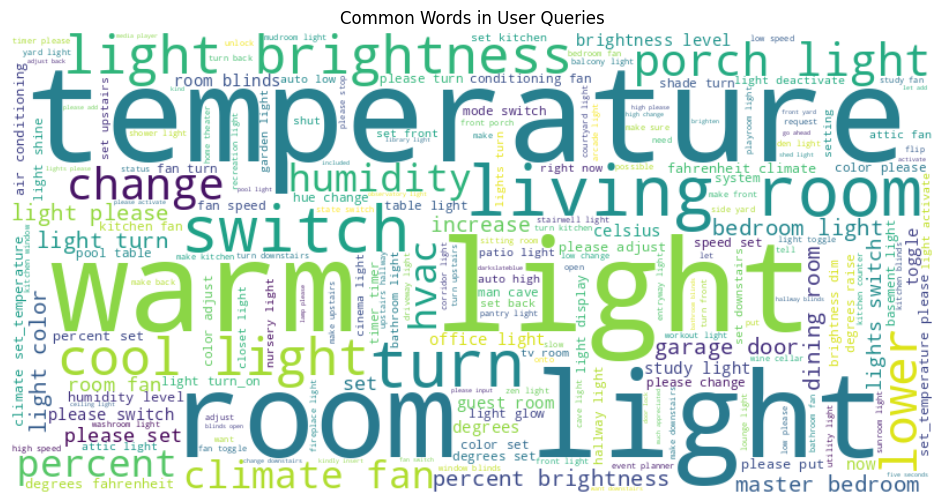

In [10]:
from wordcloud import WordCloud

all_text = " ".join(df['user'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Common Words in User Queries")
plt.show()

### Example Query-Response Pairs

In [11]:
for i in range(5):
    print("User:", df.iloc[i]['user'])
    print("Assistant:", df.iloc[i]['assistant'])
    print("Service:", df.iloc[i]['service'], " | Device:", df.iloc[i]['device'])
    print("="*60)

User: lower the kitchen blinds
Assistant: closing the blinds as you requested.
```homeassistant
{"service": "cover.close", "target_device": "cover.kitchen"}
```
Service: cover.close  | Device: cover.kitchen
User: lower the kitchen blinds
Assistant: shutting Kitchen as requested
```homeassistant
{"service": "cover.close", "target_device": "cover.kitchen"}
```
Service: cover.close  | Device: cover.kitchen
User: lower the kitchen blinds
Assistant: closing the blinds as you requested.
```homeassistant
{"service": "cover.close", "target_device": "cover.kitchen"}
```
Service: cover.close  | Device: cover.kitchen
User: lower the kitchen blinds
Assistant: closing the blinds as you requested.
```homeassistant
{"service": "cover.close", "target_device": "cover.kitchen"}
```
Service: cover.close  | Device: cover.kitchen
User: lower the kitchen blinds
Assistant: shutting Kitchen as requested
```homeassistant
{"service": "cover.close", "target_device": "cover.kitchen"}
```
Service: cover.close  | D